In [1]:
# Общие библиотеки
import pandas as pd
import numpy as np
import glob
from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
import json
from math import sin, cos

# Для создания и обучения модели
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms

# Для работы с изображениями
import cv2
from PIL import Image

# Для визуализации
import matplotlib.pyplot as plt
from IPython.display import clear_output

**Преобразовываем данные из json в DataFrame**

In [2]:
json_dir = "/content/drive/MyDrive/train/json/"

data_df = pd.DataFrame({'id': [], "left_top_x": [], 'left_top_y': [], "right_bottom_x": [], 'right_bottom_y': [], 'angle': []})

json_true = []
for _, _, files in os.walk(json_dir):
    for x in files:
        if x.endswith(".json"):
            data = json.load(open(json_dir + x))
            new_row = {'id':x.split(".")[0]+".png", 'left_top_x':data["left_top"][0], 'left_top_y':data["left_top"][1], 'right_bottom_x': data["right_bottom"][0], "right_bottom_y": data["right_bottom"][1], 'angle': data["angle"]}
            data_df = data_df.append(new_row, ignore_index=True)

data_df.head(5)

,id,left_top_x,left_top_y,right_bottom_x,right_bottom_y,angle
0,917.png,2690.0,3381.0,2615.0,4828.0,48.0
1,903.png,7181.0,2357.0,5830.0,1838.0,156.0
2,905.png,4350.0,2092.0,4527.0,3529.0,38.0
3,911.png,3371.0,4914.0,2170.0,4105.0,169.0
4,895.png,7119.0,8151.0,8010.0,7010.0,263.0


In [ ]:
data_df[data_df['id'] == '799_gen.png']

,id,left_top_x,left_top_y,right_bottom_x,right_bottom_y,angle
999,799_gen.png,1152.0,1992.0,2245.0,2943.0,356.0


In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              1600 non-null   object 
 1   left_top_x      1600 non-null   float64
 2   left_top_y      1600 non-null   float64
 3   right_bottom_x  1600 non-null   float64
 4   right_bottom_y  1600 non-null   float64
 5   angle           1600 non-null   float64
dtypes: float64(5), object(1)
memory usage: 75.1+ KB


# Загрузчик данных

Сначала напишем класс, в котором данные непосредственно загружаются и приводятся в нужный формат.


In [ ]:
class ImageDataset(Dataset):
    def __init__(self, data_df, transform=None):

        self.data_df = data_df
        self.transform = transform

    def __getitem__(self, idx):
        # достаем имя изображения и ее лейбл
        image_name, labels = self.data_df.iloc[idx]['id'], [self.data_df.iloc[idx]['left_top_x']/10496, 
                                                            self.data_df.iloc[idx]['left_top_y']/10496, 
                                                            self.data_df.iloc[idx]['right_bottom_x']/10496, 
                                                            self.data_df.iloc[idx]['right_bottom_y']/10496, 
                                                            self.data_df.iloc[idx]['angle']/360]

        
        # читаем картинку
        image = cv2.imread(f"/content/drive/MyDrive/train/img/{image_name}")

        # Меняем размер изображения
        #image = cv2.resize(image, (500, 500))

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # преобразуем, если нужно. transform it, if necessary
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(labels).float()
    
    def __len__(self):
        return len(self.data_df)

(1024, 1024, 3)


<function matplotlib.pyplot.show(*args, **kw)>

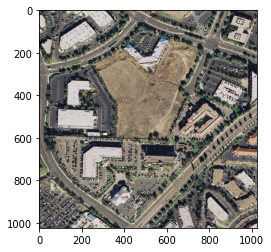

In [9]:
image = cv2.imread(f"/content/drive/MyDrive/train/img/799_gen.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape)
image = Image.fromarray(image)
#print(image.shape)
plt.imshow(image)
plt.show

Далее зададим аугментации, которые будут использоваться при обучении модели.


**Добавить другие аугментации!!**


In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

valid_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])



Посмотрим на количество данных и разделим их на тренировочную и валидационную части.


In [ ]:
from os import listdir

print("Обучающей выборки " ,len(listdir("/content/drive/MyDrive/train/img/")))
print("Тестовой выборки " ,len(listdir("/content/drive/MyDrive/test")))

# Обучающей выборки 800 --> 1600
# Тестовой выборки 400

Обучающей выборки  1600
Тестовой выборки  400


In [ ]:
# разделим датасет на трейн и валидацию, чтобы смотреть на качество
train_df, valid_df = train_test_split(data_df, test_size=0.2, random_state=13)

Каждую из выборок подадим в ранее созданный класс. 

После чего обернем это в другой класс, уже существующий в библиотеке torch - DataLoader.


In [ ]:
train_dataset = ImageDataset(train_df, train_transform)
valid_dataset = ImageDataset(valid_df, valid_transform)

**Изменить размер батчей!!!**

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=16,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=2
                                          )

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=16,
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=2
                                          )


# Вспомогательные функции


Для обучения модели нам понадобятся функции расчета метрики, построения графика обучения и непосредственно обучения.

Ниже приведена функция рассчета метрики. Важное замечание - метрика для лидерборда рассчитывается исправленной метрикой, что именно исправлено можно прочитать в разделе "Метрика".

In [ ]:
def compute_metric(data_true, data_pred, outImageW = 10496, outImageH = 10496):

    x_center_true = np.array((data_true[0] + data_true[2])/2).astype(int)
    y_center_true = np.array((data_true[1] + data_true[3])/2).astype(int)

    x_metr = x_center_true - np.array((data_pred[0] + data_pred[2])/2).astype(int)
    y_metr = y_center_true - np.array((data_pred[1] + data_pred[3])/2).astype(int)

    metr =  1 - (0.7 * 0.5 * (abs(x_metr)/outImageH + abs(y_metr)/outImageW) + 0.3 * min(abs(data_pred[4] - data_true[4]), abs( abs(data_pred[4] - data_true[4]) - 360 )) /360 )
    return metr


Функция визуализации графиков обучения.


In [ ]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()


Процесс обучения модели написан вручную без готовых функций (таких как TrainEpoch). Это дает более четкий контроль процесса обучения и возможность его кастомизировать.


In [ ]:
def train(model, criterion, optimizer, train_dataloader, test_dataloader, NUM_EPOCH,
          scheduler):
    train_loss_log = []
    val_loss_log = []
    
    train_acc_log = []
    val_acc_log = []
    
    for epoch in tqdm(range(NUM_EPOCH)):
        model.train()
        train_loss = 0.
        train_size = 0
        
        train_pred = []

        for imgs, labels in train_dataloader:
            optimizer.zero_grad()

            imgs = imgs.cuda()
            labels = labels.cuda()

            y_pred = model(imgs)

            loss = criterion(y_pred, labels)
            loss.backward()
            
            train_loss += loss.item()
            train_size += y_pred.size(0)
            train_loss_log.append((loss.data.cpu().detach().numpy() / y_pred.size(0)) * 100)
            
            y_pred[:, :4] = y_pred[:, :4] * 10496
            y_pred[:, -1] = y_pred[:, -1] * 360

            labels[:, :4] = labels[:, :4] * 10496
            labels[:, -1] = labels[:, -1] * 360

            for label, pr in zip(labels, y_pred):
                    train_pred.append(compute_metric(label.cpu().detach().numpy(), pr.cpu().detach().numpy()))

            optimizer.step()

        train_acc_log.append(train_pred)

        val_loss = 0.
        val_size = 0
        
        val_pred = []
        
        model.eval()
        
        with torch.no_grad():
            for imgs, labels in test_dataloader:
                
                imgs = imgs.cuda()
                labels = labels.cuda()
                
                pred = model(imgs)
                loss = criterion(pred, labels)

                pred[:, :4] = pred[:, :4] * 10496
                pred[:, -1] = pred[:, -1] * 360

                labels[:, :4] = labels[:, :4] * 10496
                labels[:, -1] = labels[:, -1] * 360
                
                val_loss += loss.item()
                val_size += pred.size(0)

                for label, pr in zip(labels, pred):
                    val_pred.append(compute_metric(label.cpu().detach().numpy(), pr.cpu().detach().numpy()))

        val_loss_log.append((val_loss / val_size)*100)
        val_acc_log.append(val_pred)

        scheduler.step()

        clear_output()
        plot_history(train_loss_log, val_loss_log, 'loss')
        


        print('\nTrain loss:', (train_loss / train_size)*100)
        print('Val loss:', (val_loss / val_size)*100)
        print('Train metric:', (np.mean(train_pred)))
        print('Val metric:', (np.mean(val_pred)))
        #print('train_acc_log:', train_acc_log)
        #print('val_acc_log:', val_acc_log)
        
    return train_loss_log, train_acc_log, val_loss_log, val_acc_log


# Обучение модели

В качестве модели используем resnet50, предобученный на датасете imagenet с выходным слоем размером 5, так как мы хотим предсказывать 5 параметров. Функцией потерь же будет MSELoss, используемый в задачах регрессии.

In [ ]:
#def save_log(train_loss_log,
#             val_loss_log,
#             lr_l,
#             gamma_l, 
#             model_name = 'resnet50',
#             log_path = r'/content/drive/MyDrive/submissions/model_results.txt'):
#  with open(log_path, 'a') as f:
#      f.write(f'Model: {model_name}; lr: {lr_l}, gamma: {gamma_l} \ntrain_loss: {train_loss_log[0]} - {train_loss_log[-1]}, \nval_loss_log: {val_loss_log[0]} - {val_loss_log[-1]} \n\n')
#

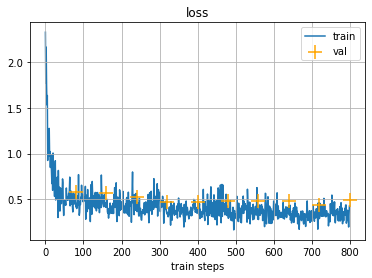

100%|██████████| 10/10 [10:15<00:00, 61.53s/it]


Train loss: 0.3459750980255194
Val loss: 0.4924743052106351
Train metric: 0.8117587854940655
Val metric: 0.7762295606115728


In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=16,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=2
                                          )

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=16,
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=2
                                          )


torch.cuda.empty_cache()

# Подргружаем модель

model_1 = models.resnet101(pretrained=True)
model_1.fc = nn.Linear(2048, 5)

model_1 = model_1.cuda()
criterion = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model_1.fc.parameters(), lr=0.001)

scheduler=optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.7)

train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(model_1, 
                                                                 criterion,
                                                                 optimizer, 
                                                                 train_loader, 
                                                                 valid_loader, 
                                                                 10,
                                                                 scheduler)


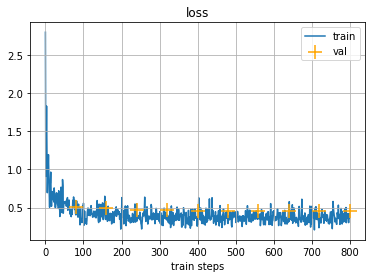

100%|██████████| 10/10 [09:32<00:00, 57.28s/it]


Train loss: 0.3769903111970052
Val loss: 0.4585743823554367
Train metric: 0.8042527769197051
Val metric: 0.790413771054609


In [ ]:

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=16,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=2
                                          )

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=16,
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=2
                                          )


torch.cuda.empty_cache()

# Подргружаем модель

wide_resnet50_2 = models.wide_resnet50_2(pretrained=True)
wide_resnet50_2.fc = nn.Linear(2048, 5)

wide_resnet50_2 = wide_resnet50_2.cuda()
criterion = torch.nn.MSELoss()

optimizer = torch.optim.Adam(wide_resnet50_2.fc.parameters(), lr=0.001)

scheduler=optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.4)

train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(wide_resnet50_2, 
                                                                 criterion,
                                                                 optimizer, 
                                                                 train_loader, 
                                                                 valid_loader, 
                                                                 10,
                                                                 scheduler)


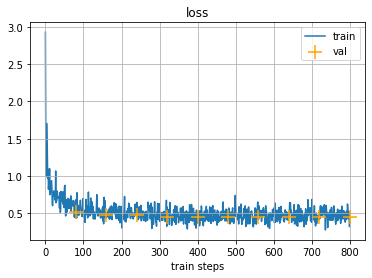

100%|██████████| 10/10 [08:34<00:00, 51.48s/it]


Train loss: 0.4805089958244935
Val loss: 0.45288920402526855
Train metric: 0.7878653138432561
Val metric: 0.786268971196762


In [ ]:

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=16,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=2
                                          )

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=16,
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=2
                                          )


torch.cuda.empty_cache()

# Подргружаем модель

model_googlenet = models.googlenet(pretrained=True)
model_googlenet.fc = nn.Linear(1024, 5)

model_googlenet = model_googlenet.cuda()
criterion = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model_googlenet.fc.parameters(), lr=0.001)

scheduler=optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.4)

train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(model_googlenet, 
                                                                 criterion,
                                                                 optimizer, 
                                                                 train_loader, 
                                                                 valid_loader, 
                                                                 10,
                                                                 scheduler)


In [ ]:
torch.cuda.empty_cache()

In [ ]:
train_transform_112 = transforms.Compose([
    transforms.Resize(112),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

valid_transform_112 = transforms.Compose([
    transforms.Resize(112),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])


# разделим датасет на трейн и валидацию, чтобы смотреть на качество
#train_df, valid_df = train_test_split(data_df, test_size=0.2, random_state=13)

train_dataset_112 = ImageDataset(train_df, train_transform_112)
valid_dataset_112 = ImageDataset(valid_df, valid_transform_112)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset_112,
                                           batch_size=16,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=2
                                          )

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset_112,
                                           batch_size=16,
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=2
                                          )

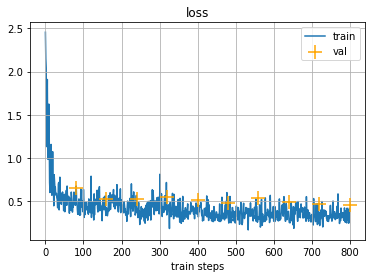

100%|██████████| 10/10 [09:12<00:00, 55.21s/it]


Train loss: 0.33943184942472726
Val loss: 0.46002870309166616
Train metric: 0.8129429795030596
Val metric: 0.7871211163815929


In [ ]:
torch.cuda.empty_cache()

# Подргружаем модель

model_resnet101_112 = models.resnet101(pretrained=True)
model_resnet101_112.fc = nn.Linear(2048, 5)

model_resnet101_112 = model_resnet101_112.cuda()
criterion = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model_resnet101_112.fc.parameters(), lr=0.001)

scheduler=optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.7)

train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(model_resnet101_112, 
                                                                 criterion,
                                                                 optimizer, 
                                                                 train_loader, 
                                                                 valid_loader, 
                                                                 10,
                                                                 scheduler)

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

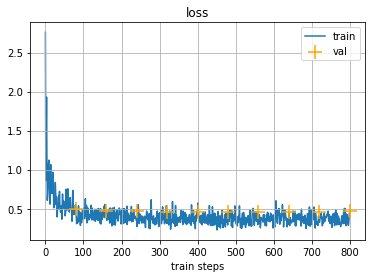

100%|██████████| 10/10 [09:28<00:00, 56.88s/it]


Train loss: 0.36922117113135755
Val loss: 0.4646046203561127
Train metric: 0.8046359899051911
Val metric: 0.7831163777861654


In [ ]:
torch.cuda.empty_cache()

# Подргружаем модель

wide_resnet50_2_112 = models.wide_resnet50_2(pretrained=True)
wide_resnet50_2_112.fc = nn.Linear(2048, 5)

wide_resnet50_2_112 = wide_resnet50_2_112.cuda()
criterion = torch.nn.MSELoss()

optimizer = torch.optim.Adam(wide_resnet50_2_112.fc.parameters(), lr=0.001)

scheduler=optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.4)

train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(wide_resnet50_2_112, 
                                                                 criterion,
                                                                 optimizer, 
                                                                 train_loader, 
                                                                 valid_loader, 
                                                                 10,
                                                                 scheduler)


In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

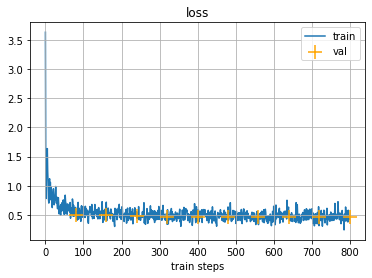

100%|██████████| 10/10 [08:38<00:00, 51.85s/it]


Train loss: 0.47235426842235034
Val loss: 0.4599245474673807
Train metric: 0.7891297799352465
Val metric: 0.7838194732028778


In [ ]:

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=16,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=2
                                          )

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=16,
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=2
                                          )


torch.cuda.empty_cache()

# Подргружаем модель

model_googlenet_112 = models.googlenet(pretrained=True)
model_googlenet_112.fc = nn.Linear(1024, 5)

model_googlenet_112 = model_googlenet_112.cuda()
criterion = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model_googlenet_112.fc.parameters(), lr=0.001)

scheduler=optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.4)

train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(model_googlenet_112, 
                                                                 criterion,
                                                                 optimizer, 
                                                                 train_loader, 
                                                                 valid_loader, 
                                                                 10,
                                                                 scheduler)


Запустим обучение и понаблюдаем за изменением лоссов.



# Проверка модели

In [ ]:
total_metric = []

for imgs, labels in valid_loader:
    imgs = imgs.cuda()
    labels = labels.cpu().detach().numpy()            
    pred = model_1(imgs)
    pred = pred.cpu().detach().numpy()    

    pred[:, :4] = pred[:, :4] * 10496
    pred[:, -1] = pred[:, -1] * 360

    labels[:, :4] = labels[:, :4] * 10496
    labels[:, -1] = labels[:, -1] * 360
    
    for label, pr in zip(labels, pred):
        total_metric.append(compute_metric(label, pr))
    
total_metric = np.mean(total_metric)
print('Valid metric:', total_metric)

Valid metric: 0.7895672381714107


In [ ]:
vgbhjkl

# Создадим предсказания на тестовом наборе данных

Для начала нужно написать класс для загрузки тестовых данных, аналогичный тому, что написан для тренировочных.

In [ ]:
class TestImageDataset(Dataset):
    def __init__(self, files, transform=None):

        self.files = files
        self.transform = transform

    def __getitem__(self, idx):

        image_name = self.files[idx]

        # читаем картинку. read the image
        image = cv2.imread(f"/content/drive/MyDrive/test/{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # преобразуем, если нужно. transform it, if necessary
        if self.transform:
            image = self.transform(image)
        
        return image
    
    def __len__(self):
        return len(self.files)


Далее собираем названия всех тестовых файлов и объявляем даталоадер с размером батча 16, так как тестовых картинок 400, а 400%16==0.

In [ ]:
test_images_dir = '/content/drive/MyDrive/test/'

for _, _, test_files in os.walk(test_images_dir):
    break

test_dataset = TestImageDataset(test_files, valid_transform)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=16,
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=2
                                          )

test_dataset_112 = TestImageDataset(test_files, valid_transform_112)

test_loader_112 = torch.utils.data.DataLoader(dataset=test_dataset_112,
                                           batch_size=16,
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=2
                                          )


Собираем предсказания в список.

In [ ]:
indexes = [x.split('.')[0] for x in test_files]

predicts = {'model_1': [],
            'wide_resnet50_2': [],
            'model_googlenet': []}
preds = []

for imgs in test_loader:
  #for model in [model_1, wide_resnet50_2, model_googlenet]:

  imgs = imgs.cuda()    
  
  pred = model_1(imgs)
  pred = pred.cpu().detach().numpy()
  pred[:, :4] = np.clip(pred[:, :4] * 10496, 0, 10496)
  pred[:, -1] = np.clip(pred[:, -1] * 360, 0, 360)
  #preds.extend(list(pred))
  predicts['model_1'].extend(list(pred))

  pred = wide_resnet50_2(imgs)
  pred = pred.cpu().detach().numpy()
  pred[:, :4] = np.clip(pred[:, :4] * 10496, 0, 10496)
  pred[:, -1] = np.clip(pred[:, -1] * 360, 0, 360)
  #preds.extend(list(pred))
  predicts['wide_resnet50_2'].extend(list(pred))

  pred = model_googlenet(imgs)
  pred = pred.cpu().detach().numpy()
  pred[:, :4] = np.clip(pred[:, :4] * 10496, 0, 10496)
  pred[:, -1] = np.clip(pred[:, -1] * 360, 0, 360)
  #preds.extend(list(pred))
  predicts['model_googlenet'].extend(list(pred))



In [ ]:
predicts['model_googlenet'][0], predicts['model_1'][0]

(array([4523.5776 , 6055.516  , 7071.2036 , 6708.1533 ,  288.21658],
       dtype=float32),
 array([ 7512.994 , 10496.    ,  6368.097 , 10496.    ,   209.5276],
       dtype=float32))

In [ ]:
indexes = [x.split('.')[0] for x in test_files]

predicts['model_resnet101_112'] = []
predicts['wide_resnet50_2_112'] = []
predicts['model_googlenet_112'] = []
preds = []

for imgs in test_loader_112:
  #for model in [model_1, wide_resnet50_2, model_googlenet]:

  imgs = imgs.cuda()    
  
  pred = model_resnet101_112(imgs)
  pred = pred.cpu().detach().numpy()
  pred[:, :4] = np.clip(pred[:, :4] * 10496, 0, 10496)
  pred[:, -1] = np.clip(pred[:, -1] * 360, 0, 360)
  #preds.extend(list(pred))
  predicts['model_resnet101_112'].extend(list(pred))

  pred = wide_resnet50_2_112(imgs)
  pred = pred.cpu().detach().numpy()
  pred[:, :4] = np.clip(pred[:, :4] * 10496, 0, 10496)
  pred[:, -1] = np.clip(pred[:, -1] * 360, 0, 360)
  #preds.extend(list(pred))
  predicts['wide_resnet50_2_112'].extend(list(pred))

  pred = model_googlenet_112(imgs)
  pred = pred.cpu().detach().numpy()
  pred[:, :4] = np.clip(pred[:, :4] * 10496, 0, 10496)
  pred[:, -1] = np.clip(pred[:, -1] * 360, 0, 360)
  #preds.extend(list(pred))
  predicts['model_googlenet_112'].extend(list(pred))



In [ ]:
np.mean([predicts['model_googlenet_112'][0], predicts['wide_resnet50_2_112'][0], predicts['model_resnet101_112'][0], 
     predicts['model_googlenet'][0], predicts['wide_resnet50_2'][0], predicts['model_1'][0]], axis = 0)

array([6290.625 , 8074.1704, 6479.75  , 7752.9224,  212.1584],
      dtype=float32)

In [ ]:
predicts['model_googlenet_112'][0], predicts['wide_resnet50_2_112'][0], predicts['model_resnet101_112'][0], predicts['model_googlenet'][0], predicts['wide_resnet50_2'][0], predicts['model_1'][0]

(array([7512.8877 , 6690.814  , 6831.0127 , 5896.7036 ,  235.47815],
       dtype=float32),
 array([5601.68   , 8646.29   , 6203.626  , 7440.742  ,  138.88112],
       dtype=float32),
 array([6412.005  , 8145.8228 , 5959.9966 , 8468.874  ,  219.40187],
       dtype=float32),
 array([4523.5776 , 6055.516  , 7071.2036 , 6708.1533 ,  288.21658],
       dtype=float32),
 array([6180.601  , 8410.583  , 6444.566  , 7507.0625 ,  181.44524],
       dtype=float32),
 array([ 7512.994 , 10496.    ,  6368.097 , 10496.    ,   209.5276],
       dtype=float32))

In [ ]:
predicts['model_1'][0]

array([ 7512.994 , 10496.    ,  6368.097 , 10496.    ,   209.5276],
      dtype=float32)

In [ ]:
from PIL import Image, ImageTransform

In [ ]:
predicts.keys()

dict_keys(['model_1', 'wide_resnet50_2', 'model_googlenet', 'model_resnet101_112', 'wide_resnet50_2_112', 'model_googlenet_112'])

In [ ]:
im = Image.open('/content/drive/MyDrive/train/original.tiff')

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (110166016 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


5601.68 8646.29
6203.626 8646.29


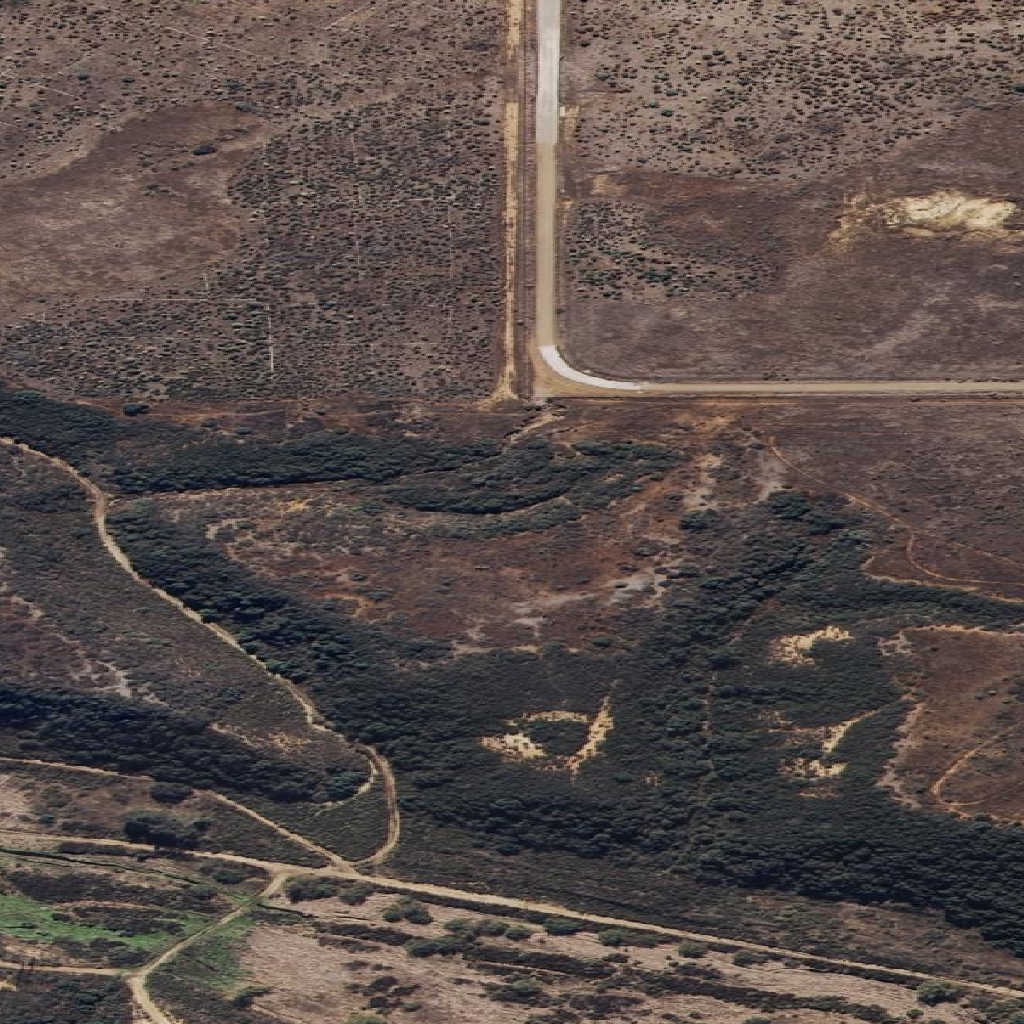

In [ ]:

model_name = 'wide_resnet50_2_112'
index = 0

left_top_x, left_top_y = predicts[model_name][index][0], predicts[model_name][index][1]
right_top_x, right_top_y = predicts[model_name][index][2], predicts[model_name][index][1]
left_bottom_x, left_bottom_y = predicts[model_name][index][0], predicts[model_name][index][3]
right_bottom_x, right_bottom_y = predicts[model_name][index][2], predicts[model_name][index][3]


trans = [left_top_x, left_top_y, left_bottom_x, left_bottom_y, right_bottom_x, right_bottom_y, right_top_x, right_top_y ]
print(left_top_x, left_top_y)
print(right_top_x, right_top_y)
im.transform((1024, 1024), ImageTransform.QuadTransform(trans))

In [ ]:
#preds =
for i in range(len(predicts['model_googlenet_112'])):
  preds.append(
      np.mean(
          [predicts['model_googlenet_112'][i], predicts['wide_resnet50_2_112'][i], predicts['model_resnet101_112'][i], 
           predicts['model_googlenet'][i], predicts['wide_resnet50_2'][i], predicts['model_1'][i]
           ], axis = 0)
  )

In [ ]:
preds[0]

array([6290.625 , 8074.1704, 6479.75  , 7752.9224,  212.1584],
      dtype=float32)

Записываем полученные предсказания в нужный для сабмита формат. После чего можно сжать все .json-файлы в архив и загрузить его на платформу.



In [ ]:
sub_dir = "/content/drive/MyDrive/submissions/20_07_(ensemble)/"
if not os.path.exists(sub_dir):
    os.makedirs(sub_dir)

json_true = []

for indx, pred in zip(indexes, preds):

    pred = [int(x) for x in pred]

    left_top = [pred[0], pred[1]]
    right_top = [pred[2], pred[1]]
    left_bottom = [pred[0], pred[3]]
    right_bottom = [pred[2], pred[3]]
        
    res = {
        'left_top': left_top,
        'right_top': right_top,
        'left_bottom': left_bottom,
        'right_bottom': right_bottom,
        'angle': pred[4]
    }

    with open(sub_dir+indx+'.json', 'w') as f:
        json.dump(res, f)
